In [1]:
from copy import deepcopy
import tqdm

import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import torch

from adaptive_mcmc.distributions.distribution import GaussianMixture
from adaptive_mcmc.samplers import base_sampler, mala, fishermala, hmc, hmcadaptive
from adaptive_mcmc.samplers.stopping_rule import TVStop, NoStop
from adaptive_mcmc.tools.benchmark import BenchmarkUtils, Benchmark

2025-01-21 00:12:02.914737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737407522.927755   19400 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737407522.931043   19400 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
seed = 123
torch.manual_seed(seed)

device = "cpu"

hparams = {
    "mala": mala.MALAParams(
        sigma=1.0,
        sigma_lr=0.015,
        target_acceptance=0.574,
        device=device,
    ),
    "fisher_mala": fishermala.FisherMALAParams(dampening=10.),
    "hmc_vanilla": hmc.HMCParams(lf_step_count=5, lf_step_size=0.5, no_grad=True),
    "hmcadaptive_vanilla": hmcadaptive.HMCAdaptiveParams(
        lf_step_count=5,
        lf_step_size=0.5,
        learning_rate=5e-3,
        truncation_level_prob=0.5,
        min_truncation_level=2,
    ),
}

In [3]:
chain_count = 15
dimensions = [100] #, 5, 10, 100, 10]
gaussian_count = 100
tv_threshold = 0.05
sample_count = 1000
sample_iter_limit = 1000
burn_in_iter_count = 1000
probe_period = 2500
cube = 5.
distance_to_mass_points = cube / 4
tail_count_cap = 1000

# stopping_rule = TVStop(threshold=tv_threshold, density_probe_count=1000,
#                        projection_count=25, tail_count_cap=tail_count_cap)

stopping_rule = NoStop(density_probe_count=500,
                       projection_count=25, tail_count_cap=tail_count_cap)

algs = {
    "fisher_mala": fishermala.FisherMALAVanilla(
        pipeline=None,
        name="FisherMALA",
        sigma_burn_in_params=hparams["fisher_mala"].copy(),
        sigma_burn_in_iter_count=500,
        prec_burn_in_params=hparams["fisher_mala"].copy(),
        prec_burn_in_iter_count=burn_in_iter_count - 500,
        sample_iter_count=sample_iter_limit,
        stopping_rule=stopping_rule,
        probe_period=probe_period
    ),
    # "mala": mala.MALAVanilla(
    #     pipeline=None,
    #     name="MALA",
    #     sigma_burn_in_params=hparams["mala"].copy(),
    #     sigma_burn_in_iter_count=burn_in_iter_count,
    #     sample_iter_count=sample_iter_limit,
    #     stopping_rule=stopping_rule,
    #     probe_period=probe_period,
    # ),
    # "hmc_vanilla": hmc.HMCVanilla(
    #     pipeline=None,
    #     name="HMCVanilla",
    #     params=hparams["hmc_vanilla"].copy(),
    #     sample_iter_count=sample_iter_limit,
    #     burn_in_iter_count=burn_in_iter_count,
    #     stopping_rule=stopping_rule,
    #     probe_period=probe_period,
    # ),
    # "hmcadaptive_vanilla": hmcadaptive.HMCAdaptiveVanilla(
    #     pipeline=None,
    #     name="HMCAdaptiveVanilla",
    #     params=hparams["hmcadaptive_vanilla"].copy(),
    #     sample_iter_count=sample_iter_limit,
    #     burn_in_iter_count=burn_in_iter_count,
    #     stopping_rule=stopping_rule,
    #     probe_period=probe_period,
    # ),
}

In [4]:
hist_data = {}
runtime = {
    dimension: dict()
    for dimension in dimensions
}
pure_runtime = deepcopy(runtime)

for dimension in tqdm.notebook.tqdm(dimensions):
    print("Processing dimension", dimension)
    hist_data[dimension] = {}

    true_means = torch.rand((gaussian_count, dimension)) * cube - cube / 2
    true_covs = torch.rand((gaussian_count, dimension, dimension))
    true_covs = (
        true_covs @ true_covs.permute(0, 2, 1) +
        torch.eye(dimension).repeat(gaussian_count, 1, 1)
    )

    gm = GaussianMixture(
        true_means,
        true_covs,
        torch.full((gaussian_count,), 1/gaussian_count, dtype=torch.float64)
    )

    starting_points = BenchmarkUtils.generate_starting_points(
        chain_count, dimension,
        true_means,
        distance_to_mass_points,
    )
    true_samples = gm.sample(sample_count)

    params = base_sampler.Params(
        target_dist=gm,
        starting_point=starting_points.clone(),
        proposal_dist=torch.distributions.MultivariateNormal(
            torch.zeros(dimension, device=device),
            torch.eye(dimension, device=device),
        ),
    )

    for alg in algs:
        print("-" * 80)
        base_meta_adj = hparams[alg].copy_update(params)
        if hasattr(base_meta_adj, "sigma"):
            base_meta_adj.sigma /= dimension

        algs[alg].load_params(base_meta_adj)
        algs[alg].load_true_samples(true_samples)
        algs[alg].run()

        hist_data[dimension][alg] = [
            algs[alg].pipeline.sample_blocks[-1].iteration.cache,
            algs[alg].pipeline.sample_blocks[-1].stop_data_hist
        ]
        runtime[dimension][alg] = algs[alg].pipeline.runtime
        pure_runtime[dimension][alg] = algs[alg].pipeline.pure_runtime
    print()

  0%|          | 0/1 [00:00<?, ?it/s]

Processing dimension 100
--------------------------------------------------------------------------------
Running FisherMALA
number of blocks: 3
processing block: 1


  0%|          | 0/500 [00:00<?, ?it/s]

processing block: 2


  0%|          | 0/500 [00:00<?, ?it/s]

processing block: 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Runtime: 12.06s



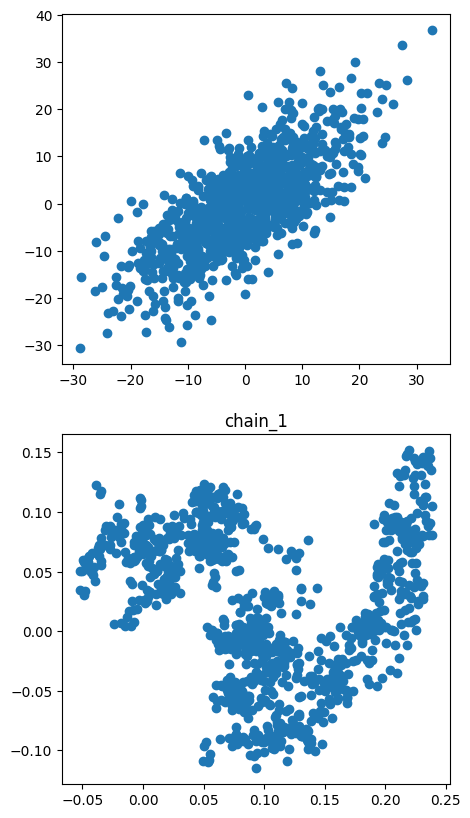

In [14]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["hmcadaptive_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
tv_threshold = 0.05

In [ ]:
pure_runtime

In [ ]:
runtime

In [ ]:
fig, axes = plt.subplots(
    nrows=len(dimensions),
    ncols=2,
    figsize=(13, 4 * len(dimensions),)
)
fig.suptitle(
    f"at most {tail_count_cap} last samples, burn-in={burn_in_iter_count}, "
    f"chain_count={chain_count}, "
    f"TV threshold={tv_threshold}\n" +
    f"mixture of {gaussian_count} gaussians with "
    "random means and covariance matrices"
)

for dim_ind in range(len(dimensions)):
    for alg_ind, alg in enumerate(algs.keys()):

        ticks_count = len(hist_data[dimensions[dim_ind]][alg][1])
        xticks = probe_period * jnp.arange(1, ticks_count + 1)

        axes[dim_ind, alg_ind].plot(
            xticks,
            [
                entry["tv_mean"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            label="TV mean"
        )
        axes[dim_ind, alg_ind].fill_between(
            xticks,
            [
                entry["tv_mean"] - 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            [
                entry["tv_mean"] + 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            alpha=0.1,
            label="95% CI"
        )
        axes[dim_ind, alg_ind].axhline(tv_threshold, color="r", linestyle="dashed")
        axes[dim_ind, alg_ind].set_title(f"{alg}, dim={dimensions[dim_ind]}")
        if dim_ind + 1 == len(dimensions):
            axes[dim_ind, alg_ind].set_xlabel("iteration")
        axes[dim_ind, alg_ind].set_ylabel("TV")
        axes[dim_ind, alg_ind].legend()

In [5]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

{'ess': np.float32(0.014571772),
 'tv_mean': Array(0.20540893, dtype=float32),
 'tv_conf_sigma': Array(0.09677804, dtype=float32),
 'wasserstein': 2861.213236819926}

In [5]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

{'ess': np.float32(0.014571771),
 'tv_mean': Array(0.20540899, dtype=float32),
 'tv_conf_sigma': Array(0.09677801, dtype=float32),
 'wasserstein': 2861.213244404562}

In [11]:
BenchmarkUtils.compute_metrics(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

{'ess': np.float32(0.019632276),
 'tv_mean': Array(0.221106, dtype=float32),
 'tv_conf_sigma': Array(0.11329235, dtype=float32),
 'wasserstein': 3026.573968632473}

In [ ]:
algs["hmcadaptive_vanilla"].pipeline.sample_blocks[-1].iteration.cache.prec[0]

In [12]:
algs["hmcadaptive_vanilla"].pipeline.sample_blocks[-1].iteration.params.entropy_weight

tensor([[100.0000],
        [100.0000],
        [ 99.9968],
        [100.0000],
        [100.0000],
        [100.0000],
        [100.0000],
        [100.0000],
        [100.0000],
        [100.0000],
        [100.0000],
        [100.0000],
        [100.0000],
        [100.0000],
        [ 99.8460]], dtype=torch.float64)

In [13]:
algs["hmcadaptive_vanilla"].pipeline.sample_blocks[-1].iteration.params.penalty_weight

tensor([[2.2982e+02],
        [1.7396e+02],
        [1.8964e+02],
        [1.9289e+02],
        [6.8733e+02],
        [8.7795e+02],
        [9.1871e+04],
        [1.3760e+04],
        [4.5328e+03],
        [2.2545e+01],
        [3.8433e+02],
        [1.0000e+05],
        [1.3512e+02],
        [9.0342e+02],
        [4.7807e+01]])

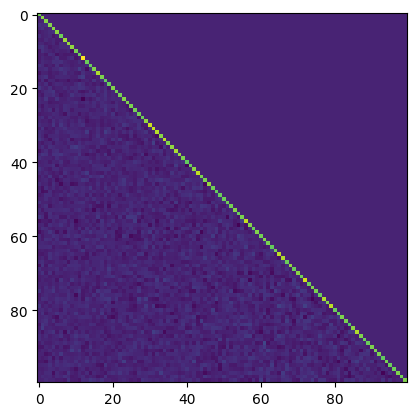

In [14]:
plt.imshow(algs["hmcadaptive_vanilla"].pipeline.sample_blocks[-1].iteration.cache.prec[7].detach().numpy())

In [15]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

{'ess': np.float32(0.016271612),
 'tv_mean': Array(0.22116105, dtype=float32),
 'tv_conf_sigma': Array(0.1307145, dtype=float32),
 'wasserstein': 3237.179206585717}

In [5]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

{'ess': np.float32(0.018171519),
 'tv_mean': Array(0.16240993, dtype=float32),
 'tv_conf_sigma': Array(0.10823723, dtype=float32),
 'wasserstein': 2464.637656582231}

### Reference

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [5]:
A = torch.randn(5, 10, 10)

In [8]:
A.sum(dim=[0,1])

tensor([-0.8660,  5.1667, -5.9270,  9.8518,  4.1769,  8.3889,  6.9534,  5.3181,
        -8.4028, -1.2018])

In [7]:
trace_prec = (A[..., None, :] @ A[..., None]).sum(dim=1)
trace_prec

tensor([[[ 99.8616]],

        [[103.3391]],

        [[121.7624]],

        [[113.4422]],

        [[ 97.6431]]])

In [8]:
A[..., None].shape

torch.Size([5, 10, 10, 1])

In [9]:
A[..., None, :].shape

torch.Size([5, 10, 1, 10])

In [10]:
(A[..., None, :] @ A[..., None]).squeeze()

tensor([[10.8266, 11.0844, 19.2692,  1.7767,  8.7668,  6.8647,  8.3898, 17.5917,
          4.9949, 10.2967],
        [ 7.2808, 13.1025, 16.0558,  2.8901,  6.4666, 12.3374, 11.5678,  7.1342,
         10.1036, 16.4003],
        [20.0383,  4.9744, 13.4483, 11.8283, 13.1094, 14.5962, 16.2507, 10.9609,
          9.4372,  7.1187],
        [12.3617, 13.4005,  6.4126, 12.8242, 17.7334, 14.0835,  8.6756,  9.2994,
          9.1427,  9.5087],
        [11.3196,  8.8221, 20.2851,  6.0830,  8.8054,  8.1989,  7.9841, 11.1879,
          9.1439,  5.8132]])

In [11]:
torch.allclose(
    torch.einsum("...ij,...ij->...", A, A),
    (A[..., None, :] @ A[..., None]).squeeze().sum(dim=1)
)

True